In [1]:
import os
import sys

sys.path.append(os.getcwd() + '/../scripts/')

In [2]:
%matplotlib notebook
#from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
import matplotlib.pyplot as plt
#from matplotlib import cm # required for colors

from functools import partial

import numpy as np
np.seterr(all='raise')

from scipy.optimize import minimize

In [3]:
from pymor.core.logger import set_log_levels
set_log_levels({'online_adaptive_lrbms': 'DEBUG',
                'OS2015_academic_problem': 'INFO',
                'discretize_elliptic': 'INFO',
                'offline': 'INFO',
                'online_enrichment': 'INFO'})

# setting up the reference discretization

In [4]:
from OS2015_academic_problem import init_grid_and_problem

config = {'num_coarse_grid_elements': [4, 4], 
          'num_grid_refinements': 2,
          'num_grid_subdomains': [2, 2], 
          'num_grid_oversampling_layers': 4, # num_grid_oversampling_layers has to exactly cover one subdomain!
          'initial_RB_order': 0,
          'enrichment_target_error': -1,
          'marking_doerfler_theta': -1,
          'marking_max_age': -1}

grid_and_problem_data = init_grid_and_problem(config)

mu_bar = grid_and_problem_data['mu_bar']
parameter_range = grid_and_problem_data['parameter_range']
parameter_range = (parameter_range[0], parameter_range[1])

initial_guess = 0.5*(parameter_range[0] + parameter_range[1])

00:01 OS2015_academic_problem: initializing grid and problem ... 


In [5]:
from discretize_elliptic import discretize

block_SWIPDG_disc, block_space, enrichment_local_boundary_info = discretize(grid_and_problem_data)
block_SWIPDG_disc.disable_logging()

parameter_space = block_SWIPDG_disc.parameter_space
parameter_type = block_SWIPDG_disc.parameter_type
parse_parameter = block_SWIPDG_disc.parse_parameter
mu_bar = parse_parameter(mu_bar)

00:03 discretize_block_SWIPDG: discretizing ... 


In [6]:
# this is required to estimate the target error for the online enrichment
print('estimating some detailed errors:')
detailed_errors = []
for mu in parameter_range:
    mu = parse_parameter(mu)
    print('  {}: '.format(mu), end='', flush=True)
    U = block_SWIPDG_disc.solve(mu)
    estimate = block_SWIPDG_disc.estimate(U, mu=mu)
    print(estimate)
    detailed_errors.append(estimate)

estimating some detailed errors:
  {diffusion: [0.1]}: 0.815510144764
  {diffusion: [1]}: 0.809729083207


In [7]:
# as a result of the above, we set
config['enrichment_target_error'] = 1.
config['marking_doerfler_theta'] = 0.33
config['marking_max_age'] = 2

# minimizing using the reference discretization

computing some detailed quantities of interest ... done


<IPython.core.display.Javascript object>


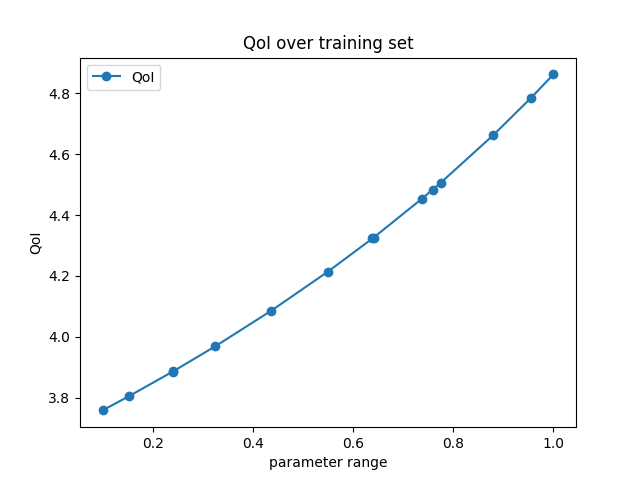

In [8]:
def reference_quantity_of_interest(mu):
    return block_SWIPDG_disc.rhs.apply(block_SWIPDG_disc.solve(mu)).data[0]

print('computing some detailed quantities of interest ... ', end='')

training_set = parameter_space.sample_uniformly(5)
training_set.extend(parameter_space.sample_randomly(10))
training_set = [mu['diffusion'] for mu in training_set]
training_set.sort()
reference_quantities_of_interest = [reference_quantity_of_interest(mu) for mu in training_set]

print('done')

plt.plot(training_set, reference_quantities_of_interest, '-o', label='QoI')
plt.title('QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing reference quantity of interest .... succeded!
  mu_min:    {diffusion: [0.1]}
  QoI(mu_min): 3.7581405695759287
  num iterations:     1
  num function calls: 4


<IPython.core.display.Javascript object>


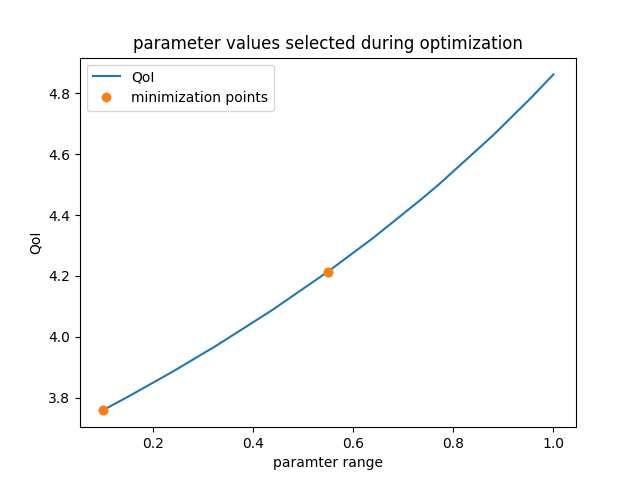

In [9]:
print('minimizing reference quantity of interest ', end='')

reference_minimization_data = {'num_evals': 0,
                               'evaluations' : [],
                               'evaluation_points': []}


def quantity_of_interest(function, data, mu):
    print('.', end='')
    QoI = function(mu)
    #print('QoI({}) = '.format(mu), end='', flush=True)
    #print(QoI)
    data['num_evals'] += 1
    data['evaluation_points'].append(parse_parameter(mu)['diffusion'][0])
    data['evaluations'].append(QoI)
    return QoI


def report(result, data):
    if (result.status != 0):
        print(' failed!')
    else:
        print(' succeded!')
        print('  mu_min:    {}'.format(parse_parameter(result.x)))
        print('  QoI(mu_min): {}'.format(result.fun[0]))
        print('  num iterations:     {}'.format(result.nit))
        print('  num function calls: {}'.format(data['num_evals']))

result = minimize(partial(quantity_of_interest, reference_quantity_of_interest, reference_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, reference_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

# setting up the standard RB discretization

In [10]:
print('reducing with standard RB:', flush=True)

from pymor.algorithms.greedy import greedy
from pymor.discretizations.basic import StationaryDiscretization
from pymor.parameters.functionals import GenericParameterFunctional
from pymor.reductors.coercive import CoerciveRBReductor

from discretize_elliptic import alpha

def coercivity_estimator(mu):
    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))

SWIPDG_disc = StationaryDiscretization(
    block_SWIPDG_disc.operators['global_op'],
    block_SWIPDG_disc.operators['global_rhs'],
    products={'energy_dg_mu_bar': block_SWIPDG_disc.operators['global_op'].assemble(mu_bar)},
    parameter_space=parameter_space,
    name='SWIPDG')

RB_reductor = CoerciveRBReductor(
    SWIPDG_disc,
    product=SWIPDG_disc.energy_dg_mu_bar_product,
    coercivity_estimator=GenericParameterFunctional(coercivity_estimator, parameter_type))

RB_greedy_data = greedy(SWIPDG_disc, RB_reductor, training_set,
                        extension_params={'method': 'gram_schmidt'},
                        max_extensions=len(training_set))

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']
RB_greedy_mus = [mu[0] for mu in RB_greedy_mus]

print('RB system is of siez {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
print('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

reducing with standard RB:


00:18 greedy: Started greedy search on 15 samples
00:18 greedy: Reducing ...
00:18 |   CoerciveRBReductor: RB projection ...
00:19 |   CoerciveRBReductor: Assembling error estimator ...
00:19 |   |   ResidualReductor: Estimating residual range ...
00:19 |   |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
00:19 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:19 |   |   ResidualReductor: Projecting residual operator ...
00:19 greedy: Estimating errors ...
00:19 greedy: Maximum error after 0 extensions: 2.205051320161316 (mu = [ 0.1])
00:19 greedy: Computing solution snapshot for mu = [ 0.1] ...
00:19 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [0.1]} ...
00:19 greedy: Extending basis with solution snapshot ...
      
00:19 greedy: Reducing ...
00:19 |   CoerciveRBReductor: RB projection ...
00:19 |   CoerciveRBReductor: Assembling error estimator ...
00:19 |   |   ResidualReductor: Estimating residual range ...
00:19 |   |  

00:19 |   CoerciveRBReductor: Assembling error estimator ...
00:19 |   |   ResidualReductor: Estimating residual range ...
00:19 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 8 ...
00:19 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
00:19 |   |   |   |   gram_schmidt: Orthonormalizing vector 18 again
00:19 |   |   ResidualReductor: Projecting residual operator ...
00:19 greedy: Estimating errors ...
00:19 greedy: Maximum error after 9 extensions: 5.0210531583939226e-11 (mu = [ 0.87955853])
00:19 greedy: Computing solution snapshot for mu = [ 0.87955853] ...
00:19 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [0.8795585311974417]} ...
00:19 greedy: Extending basis with solution snapshot ...
00:19 |   gram_schmidt: Removing linear dependent vector 9
00:19 |   greedy: Extension failed. Stopping now.
00:19 greedy: Greedy search took 0.831444263458252 seconds


RB system is of siez 9x9
maximum estimated model reduction error over training set: 5.0210531583939226e-11


<IPython.core.display.Javascript object>


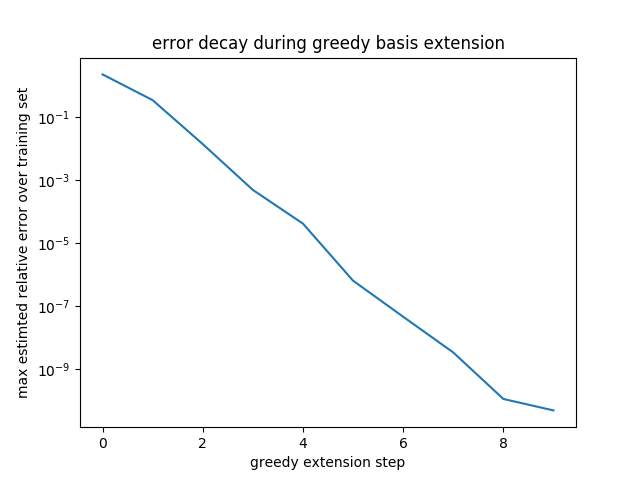

In [11]:
RB_rd = RB_greedy_data['reduced_discretization']
RB_rd.disable_logging()

plt.plot(list(range(num_RB_greedy_extensions)) + [len(range(num_RB_greedy_extensions))],
         RB_greedy_errors)
plt.yscale('log')
plt.title('error decay during greedy basis extension')
plt.xlabel('greedy extension step')
plt.ylabel('max estimted relative error over training set')

# minimizing using the standard RB discretization

<IPython.core.display.Javascript object>


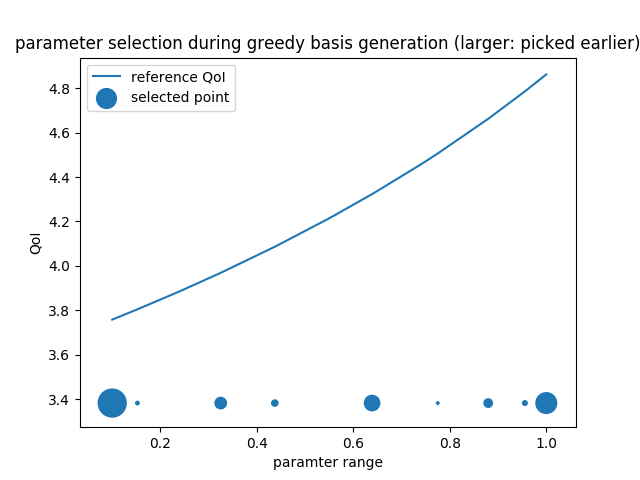

In [12]:
def RB_quantity_of_interest(mu):
    return RB_rd.rhs.apply(RB_rd.solve(mu)).data[0]

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.scatter(RB_greedy_mus,
            [0.9*np.min(reference_quantities_of_interest) for mu in RB_greedy_mus],
            s=np.exp(6.*np.linspace(1, 0.1, len(RB_greedy_mus))),
            label='selected point')
plt.title('parameter selection during greedy basis generation (larger: picked earlier)')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

computing some RB quantities of interest ... done
L-infty error of QoI over training set: 5.210942788380635e-12


<IPython.core.display.Javascript object>


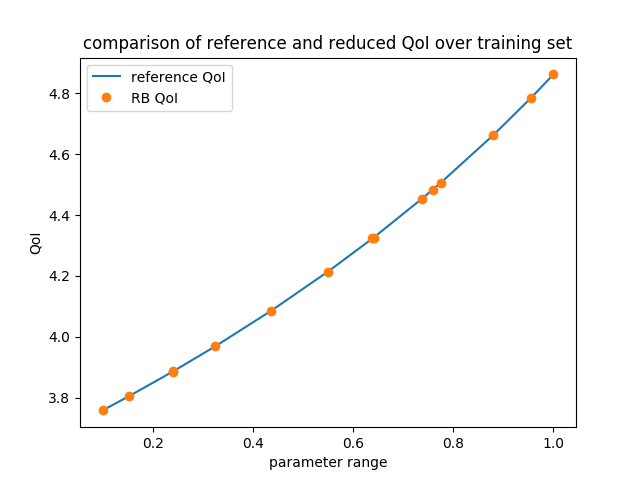

In [13]:
print('computing some RB quantities of interest ... ', end='')
RB_quantities_of_interest = [RB_quantity_of_interest(mu) for mu in training_set]
print('done')

print('L-infty error of QoI over training set: {}'.format(
    np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(RB_quantities_of_interest)))
))

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(training_set, RB_quantities_of_interest, 'o', label='RB QoI')
plt.title('comparison of reference and reduced QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing reduced quantity of interest .... succeded!
  mu_min:    {diffusion: [0.1]}
  QoI(mu_min): 3.7581405695811396
  num iterations:     1
  num function calls: 4


<IPython.core.display.Javascript object>


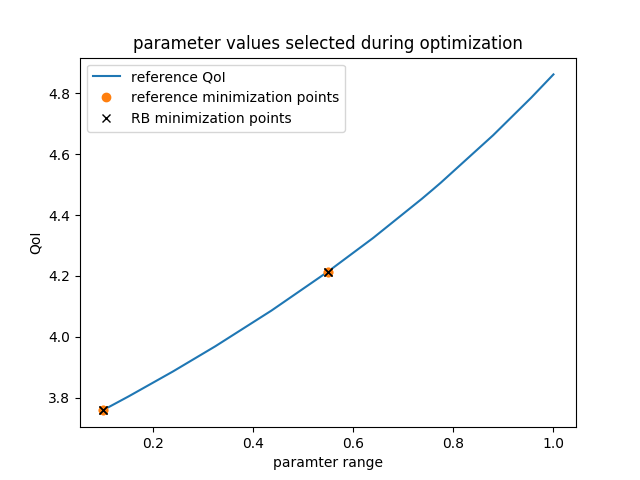

In [14]:
print('minimizing reduced quantity of interest ', end='')

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': []}

result = minimize(partial(quantity_of_interest, RB_quantity_of_interest, RB_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, RB_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
plt.plot(RB_minimization_data['evaluation_points'],
         [RB_quantity_of_interest(mu) for mu in RB_minimization_data['evaluation_points']],
         'kx', label='RB minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

# setting up the LRBMS discretization

In [15]:
from offline import init_local_reduced_bases

LRBMS_reductor = init_local_reduced_bases(block_SWIPDG_disc, block_space, config['initial_RB_order'])

#from pymor.core.exceptions import ExtensionError
#
#print('adding some global solution snapshots to reduced basis ...', flush=True)
#for mu in parameter_range:
#    U = d.solve(mu)
#    try:
#        reductor_blocked.extend_basis(U)
#    except ExtensionError:
#        pass
#print('')

print('reducing:', flush=True)
LRBMS_rd = LRBMS_reductor.reduce()
LRBMS_rd = LRBMS_rd.with_(estimator=block_SWIPDG_disc.estimator)
LRBMS_rd.disable_logging()
print('initial reduced (LRBMS) system is of size {}x{}'.format(LRBMS_rd.solution_space.dim,
                                                               LRBMS_rd.solution_space.dim))

00:38 init_local_reduced_bases: initializing local reduced bases with DG shape functions of up to order 0 ... 


reducing:


00:38 GenericRBSystemReductor: Projecting local_energy_dg_product_0: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
00:38 GenericRBSystemReductor: Projecting nonconformity_0: R^384 --> R^384  (parameter type: {}, class: BlockOperator)
00:38 GenericRBSystemReductor: Projecting residual_functional_0: R^384 --> R^1  (parameter type: {diffusion: (1,)}, class: LincombOperator)
00:38 GenericRBSystemReductor: Projecting residual_0: R^384 --> R^384  (parameter type: {}, class: LincombOperator)
00:38 GenericRBSystemReductor: Projecting diffusive_flux_0: R^384 --> R^384  (parameter type: {}, class: LincombOperator)
00:38 GenericRBSystemReductor: Projecting local_energy_dg_product_1: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
00:38 GenericRBSystemReductor: Projecting nonconformity_1: R^384 --> R^384  (parameter type: {}, class: BlockOperator)
00:39 GenericRBSystemReductor: Projecting residual_functional_1: R^384 --> R^1  (parameter type: {diffusion: (1,

initial reduced (LRBMS) system is of size 4x4


# minimizing using the LRBMS discretization

## using the insufficient initial basis

computing some initial LRBMS reduced quantities of interest ...
L-infty error w.r.t. reference QoI: 4.719400321309333
L-infty error w.r.t RB QoI: 4.719400321308372


<IPython.core.display.Javascript object>


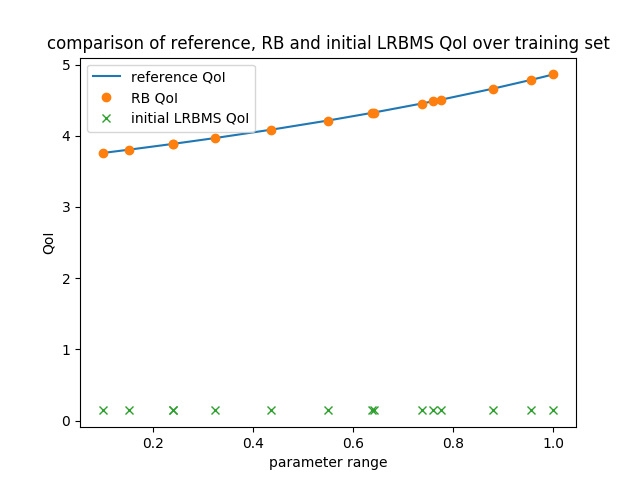

In [16]:
def LRBMS_quantity_of_interest(mu):
    return LRBMS_rd.rhs.apply(LRBMS_rd.solve(mu)).data[0]

print('computing some initial LRBMS reduced quantities of interest ...')

LRBMS_quantities_of_interest = [LRBMS_quantity_of_interest(mu) for mu in training_set]

print('L-infty error w.r.t. reference QoI: {}'.format(
    np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(LRBMS_quantities_of_interest)))
))
print('L-infty error w.r.t RB QoI: {}'.format(
    np.max(np.abs(np.array(RB_quantities_of_interest) - np.array(LRBMS_quantities_of_interest)))
))

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(training_set, RB_quantities_of_interest, 'o', label='RB QoI')
plt.plot(training_set, LRBMS_quantities_of_interest, 'x', label='initial LRBMS QoI')
plt.title('comparison of reference, RB and initial LRBMS QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing initial LRBMS quantity of interest .... succeded!
  mu_min:    {diffusion: [0.5499999972244425]}
  QoI(mu_min): 0.14285100323680794
  num iterations:     1
  num function calls: 4


<IPython.core.display.Javascript object>


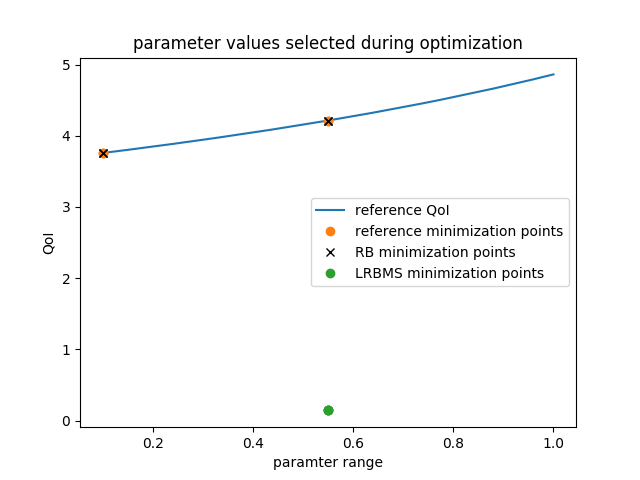

In [17]:
print('minimizing initial LRBMS quantity of interest ', end='')

LRBMS_minimization_data = {'num_evals': 0,
                           'evaluations' : [],
                           'evaluation_points': []}

result = minimize(partial(quantity_of_interest, LRBMS_quantity_of_interest, LRBMS_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, LRBMS_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
plt.plot(RB_minimization_data['evaluation_points'],
         [RB_quantity_of_interest(mu) for mu in RB_minimization_data['evaluation_points']],
         'kx', label='RB minimization points')
plt.plot(LRBMS_minimization_data['evaluation_points'],
         [LRBMS_quantity_of_interest(mu) for mu in LRBMS_minimization_data['evaluation_points']],
         'o', label='LRBMS minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

## using the adaptive online enrichment

In [18]:
print('minimizing adaptive LRBMS quantity of interest ', end='')

from online_enrichment import AdaptiveEnrichment

online_adaptive_LRBMS = AdaptiveEnrichment(grid_and_problem_data,
                                           block_SWIPDG_disc, block_space, enrichment_local_boundary_info,
                                           LRBMS_reductor, LRBMS_rd,
                                           config['enrichment_target_error'],
                                           config['marking_doerfler_theta'],
                                           config['marking_max_age'])
online_adaptive_LRBMS.disable_logging()
for ii in ('online_enrichment',
           'pymor.algorithms.gram_schmidt',
           'pymor.reductors.system'):
    set_log_levels({ii: 'WARN'})

adaptive_LRBMS_minimization_data = {'num_evals': 0,
                                    'evaluation_points': [],
                                    'evaluations' : [],
                                    'intermediate_evaluations' : [],
                                    'intermediate_evaluation_points': [],
                                    'num_local_solves': []}


def adaptive_LRBMS_quantity_of_interest(mu):
    
    num_solves = [0]
    
    def callback(rd_, U_, mu_, data_):
        adaptive_LRBMS_minimization_data['intermediate_evaluation_points'].append(mu_['diffusion'][0])
        QoI = rd_.rhs.apply(U_).data[0]
        adaptive_LRBMS_minimization_data['intermediate_evaluations'].append(QoI)
        num_solves[0] += data_['local_problem_solves']

    mu = parse_parameter(mu)
    U, rd, _ = online_adaptive_LRBMS.solve(mu, callback=callback)
    
    adaptive_LRBMS_minimization_data['num_local_solves'].append(num_solves[0])
    
    return rd.rhs.apply(U).data[0]


result = minimize(partial(quantity_of_interest,
                          adaptive_LRBMS_quantity_of_interest,
                          adaptive_LRBMS_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, adaptive_LRBMS_minimization_data)

minimizing adaptive LRBMS quantity of interest .... succeded!
  mu_min:    {diffusion: [0.1]}
  QoI(mu_min): 3.7568926828971962
  num iterations:     1
  num function calls: 4


<IPython.core.display.Javascript object>


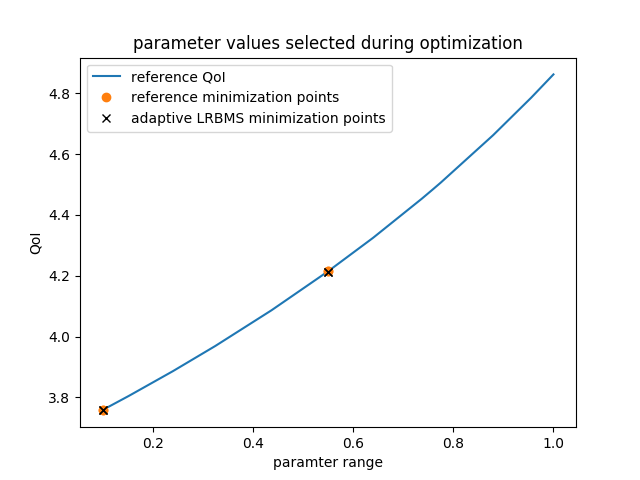

In [19]:
evaluation_points = adaptive_LRBMS_minimization_data['evaluation_points'].copy()

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
plt.plot(evaluation_points,
         [adaptive_LRBMS_quantity_of_interest(mu) for mu in evaluation_points],
         'kx', label='adaptive LRBMS minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

<IPython.core.display.Javascript object>


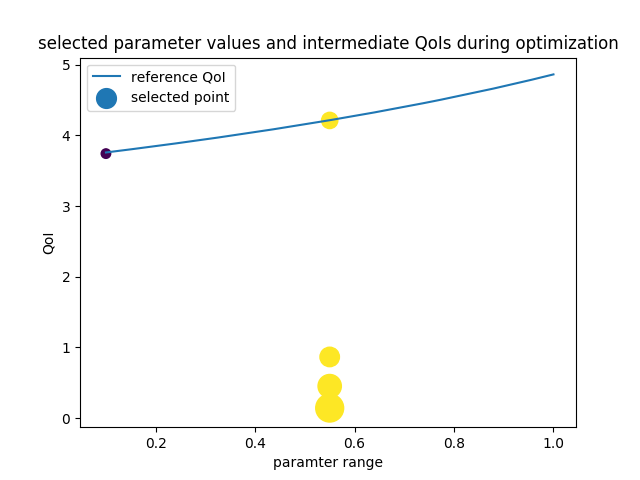

In [20]:
intermediate_evaluation_points = adaptive_LRBMS_minimization_data['intermediate_evaluation_points'].copy()
intermediate_evaluations = adaptive_LRBMS_minimization_data['intermediate_evaluations'].copy()

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.scatter(intermediate_evaluation_points,
            intermediate_evaluations,
            s=1.*np.exp(6.*np.linspace(1, 0.1, len(intermediate_evaluations))),
            c=intermediate_evaluation_points,
            label='selected point')
plt.title('selected parameter values and intermediate QoIs during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

In [22]:
num_local_solves = adaptive_LRBMS_minimization_data['num_local_solves'].copy()

for name, data in {'evaluation_points': evaluation_points,
                   'num_local_solves': num_local_solves,
                   'intermediate_evaluation_points': intermediate_evaluation_points,
                   'intermediate_evaluations': intermediate_evaluations}.items():
    print('{}:'.format(name))
    for value in data:
        print('  {}'.format(value))
    print('')

print('SOMETHINGS STILL WRONG HERE!')

evaluation_points:
  0.55
  0.5500000100000001
  0.1
  0.10000001

num_local_solves:
  7
  0
  6
  0
  0
  0
  0
  0

intermediate_evaluation_points:
  0.55
  0.55
  0.55
  0.55
  0.55
  0.5500000100000001
  0.1
  0.1
  0.1
  0.1
  0.1
  0.10000001
  0.55
  0.5500000100000001
  0.1
  0.10000001

intermediate_evaluations:
  [ 0.142851]
  [ 0.45333106]
  [ 0.86590314]
  [ 4.21108034]
  [ 4.21269005]
  [ 4.21269006]
  [ 3.74181357]
  [ 3.74384738]
  [ 3.74670534]
  [ 3.75513086]
  [ 3.75689268]
  [ 3.75689269]
  [ 4.21363318]
  [ 4.21363319]
  [ 3.75689268]
  [ 3.75689269]

SOMETHINGS STILL WRONG HERE!
